# Wind Downscaling


In [1]:
import os
from datetime import date, datetime
from pathlib import Path
from dotenv import load_dotenv
from data.data_generator import BatchGenerator, NaiveDecoder, LocalFileProvider, S3FileProvider
from gan import train, metrics
from gan.models import make_generator_no_noise
load_dotenv()
import numpy as np
import tensorflow as tf
import tensorflow.keras.callbacks as cb
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
import pandas as pd

Num GPUs Available: 0


## Set configuration

In [2]:
DATA_ROOT = Path('./data')
ERA5_DATA_FOLDER = DATA_ROOT / 'ERA5'
COSMO1_DATA_FOLDER = DATA_ROOT / 'COSMO1'
DEM_DATA_FILE = DATA_ROOT / 'dem/Switzerland-90m-DEM.tif'
PROCESSED_DATA_FOLDER = DATA_ROOT / 'img_prediction_files'
DATA_ROOT.mkdir(parents=True, exist_ok=True)
ERA5_DATA_FOLDER.mkdir(exist_ok=True)
COSMO1_DATA_FOLDER.mkdir(exist_ok=True)
DEM_DATA_FILE.parent.mkdir(exist_ok=True)
PROCESSED_DATA_FOLDER.mkdir(exist_ok=True)
cosmoblurred = True
run_id=datetime.today().strftime('%Y%m%d_%H%M')
data_provider = 'local'

In [3]:
# Start and end date for the data - should be in the 2016-2020 range
START_DATE = date(2017,1,1)
END_DATE = date(2017,3,31)
NUM_DAYS = (END_DATE-START_DATE).days + 1
# Number of consecutive images to form a sequence
SEQUENCE_LENGTH = 3
# Size of the high resolution image to be produced
IMG_SIZE = 64
# Number of sequences per batch
BATCH_SIZE = 8

In [4]:
TOPO_PREDICTORS = ['tpi_500', 'slope', 'aspect']
HOMEMADE_PREDICTORS = ['e_plus', 'e_minus', 'w_speed', 'w_angle']
ERA5_PREDICTORS_SURFACE = ['u10', 'v10', 'blh', 'fsr', 'sp', 'sshf']
ERA5_PREDICTORS_Z500 = ['z']
if cosmoblurred:
    ALL_INPUTS = ['U_10M', 'V_10M'] + HOMEMADE_PREDICTORS + TOPO_PREDICTORS
    input_pattern = 'x_cosmo_{date}.nc'
    run_id = f'{run_id}_cosmo_blurred'
else:
    ALL_INPUTS = ERA5_PREDICTORS_Z500 + ERA5_PREDICTORS_SURFACE + TOPO_PREDICTORS + HOMEMADE_PREDICTORS
    input_pattern = 'x_{date}.nc'
ALL_OUTPUTS = ['U_10M', 'V_10M']
BATCH_WORKERS = os.cpu_count()
if data_provider == 'local':
    input_provider = LocalFileProvider(PROCESSED_DATA_FOLDER, input_pattern)
    output_provider = LocalFileProvider(PROCESSED_DATA_FOLDER, 'y_{date}.nc')
elif data_provider == 's3':
    input_provider = S3FileProvider('wind-downscaling', 'img_prediction_files', pattern=input_pattern)
    output_provider = S3FileProvider('wind-downscaling', 'img_prediction_files', pattern='y_{date}.nc')
else:
    raise ValueError(f'Wrong value for data provider {data_provider}: please choose between s3 and local')
AVAIL_DATES = [pd.to_datetime(v) for v in
               set(input_provider.available_dates).intersection(output_provider.available_dates)]
START_DATE = min(AVAIL_DATES)
END_DATE = max(AVAIL_DATES)
batch_gen = BatchGenerator(input_provider, output_provider,
                                    decoder=NaiveDecoder(normalize=True),
                                    sequence_length=SEQUENCE_LENGTH,
                                    patch_length_pixel=IMG_SIZE, batch_size=BATCH_SIZE,
                                    input_variables=ALL_INPUTS,
                                    output_variables=ALL_OUTPUTS,
                                    start_date=START_DATE, end_date=END_DATE,
                                    num_workers=BATCH_WORKERS)
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)


In [5]:
inputs = []
outputs = []
with batch_gen as batch:
    for b in range(NUM_DAYS):
        print(f'Creating batch {b+1}/{NUM_DAYS}')
        x, y = next(batch)
        inputs.append(x)
        outputs.append(y)
inputs = np.concatenate(inputs, axis=0)
outputs = np.concatenate(outputs, axis=0)
print(f"Inputs: {inputs.shape}")
print(f"Outputs: {outputs.shape}")

Creating batch 1/90
Creating batch 2/90
Creating batch 3/90
Creating batch 4/90
Creating batch 5/90
Creating batch 6/90
Creating batch 7/90
Creating batch 8/90
Creating batch 9/90
Creating batch 10/90
Creating batch 11/90
Creating batch 12/90
Creating batch 13/90
Creating batch 14/90
Creating batch 15/90
Creating batch 16/90
Creating batch 17/90
Creating batch 18/90
Creating batch 19/90
Creating batch 20/90
Creating batch 21/90
Creating batch 22/90
Creating batch 23/90
Creating batch 24/90
Creating batch 25/90
Creating batch 26/90
Creating batch 27/90
Creating batch 28/90
Creating batch 29/90
Creating batch 30/90
Creating batch 31/90
Creating batch 32/90
Creating batch 33/90
Creating batch 34/90
Creating batch 35/90
Creating batch 36/90
Creating batch 37/90
Creating batch 38/90
Creating batch 39/90
Creating batch 40/90
Creating batch 41/90
Creating batch 42/90
Creating batch 43/90
Creating batch 44/90
Creating batch 45/90
Creating batch 46/90
Creating batch 47/90
Creating batch 48/90
C

In [6]:
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)

In [7]:
generator = make_generator_no_noise(image_size=IMG_SIZE, in_channels=INPUT_CHANNELS,
                                        out_channels=OUT_CHANNELS,
                                        n_timesteps=SEQUENCE_LENGTH)
print(f"Generator: {generator.count_params():,} weights")
generator.compile(optimizer=train.generator_optimizer(),
                  metrics=[metrics.AngularCosineDistance(),
                           metrics.LogSpectralDistance(),
                           metrics.WeightedRMSEForExtremes(),
                           metrics.WindSpeedWeightedRMSE(),
                           metrics.SpatialKS()],
                  loss=train.generator_loss)

Generator: 1,604,802 weights


In [8]:
checkpoint_path_weights = Path('./checkpoints/generator') / run_id / 'weights-{epoch:02d}.ckpt'
checkpoint_path_weights.parent.mkdir(exist_ok=True, parents=True)
log_path = Path('./logs/generator') / run_id
if log_path.exists():
    log_path_str = str(log_path)
    !rm -rf {log_path_str}

In [9]:
%load_ext tensorboard
%tensorboard --logdir=$log_path

In [10]:
import matplotlib.pyplot as plt
def show(images, dims=1, legends=None):
    fig, axes = plt.subplots(ncols= len(images), figsize=(10, 10))
    for ax, im in zip(axes, images):
        for i in range(dims):
            label = legends[i] if legends is not None else ''
            ax.imshow(im[0, :, :, i], cmap='jet')
            ax.set_title(label)
            ax.axis('off')
    plt.show()
    return fig

In [11]:
class ShowCallback(tf.keras.callbacks.Callback):
    def __init__(self, dims):
        self.dims = dims
        
    def on_epoch_begin(self, epoch, logs):
        show(self.model(inputs[:self.dims]))

In [12]:
callbacks = [
        cb.TensorBoard(log_path, write_images=True, update_freq='batch'),
        cb.ProgbarLogger('steps'),
        cb.TerminateOnNaN(),
        cb.ModelCheckpoint(str(checkpoint_path_weights), save_best_only=False, period=10,
                           save_weights_only=True),
        ShowCallback(3),
    ]

In [13]:
fig = show(inputs[:3])

In [14]:
fig = show(outputs[:3])

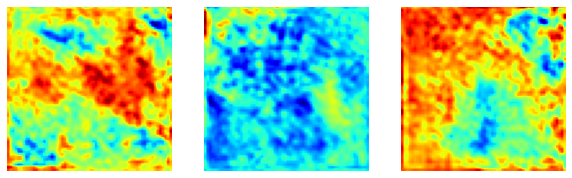

In [15]:
fig = show(generator(inputs[:3]))

Epoch 1/50


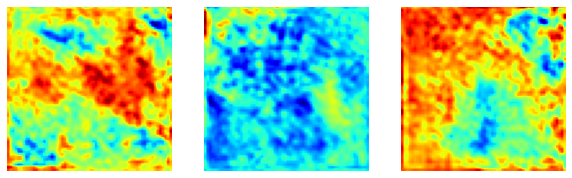

23/23 [==============================] - 95s 2s/step - loss: 3.7629 - acd: 0.4283 - lsd: 10.3108 - extreme_rmse: 0.7572 - ws_weighted_rmse: 3.7629 - spatial_ks: 0.6054
Epoch 2/50


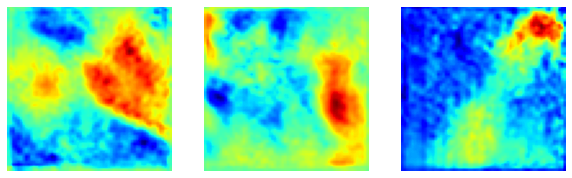

23/23 [==============================] - 43s 2s/step - loss: 2.9192 - acd: 0.3309 - lsd: 11.2068 - extreme_rmse: 0.5359 - ws_weighted_rmse: 2.9192 - spatial_ks: 0.5881
Epoch 3/50


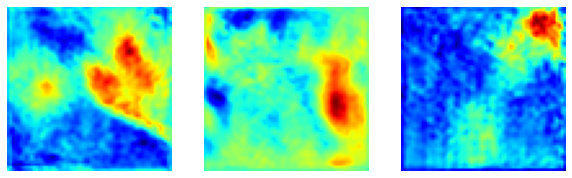

23/23 [==============================] - 46s 2s/step - loss: 2.5003 - acd: 0.2941 - lsd: 10.8796 - extreme_rmse: 0.4566 - ws_weighted_rmse: 2.5003 - spatial_ks: 0.5341
Epoch 4/50


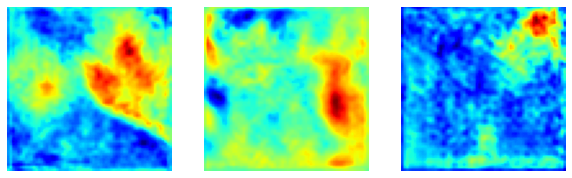

23/23 [==============================] - 45s 2s/step - loss: 2.3739 - acd: 0.2769 - lsd: 10.4006 - extreme_rmse: 0.4356 - ws_weighted_rmse: 2.3739 - spatial_ks: 0.5187
Epoch 5/50


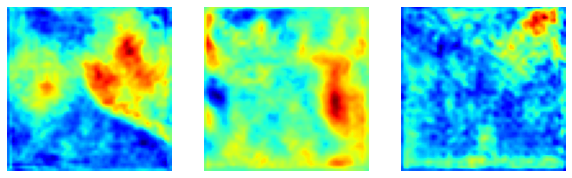

23/23 [==============================] - 47s 2s/step - loss: 2.3314 - acd: 0.2603 - lsd: 10.0351 - extreme_rmse: 0.4303 - ws_weighted_rmse: 2.3314 - spatial_ks: 0.5129
Epoch 6/50


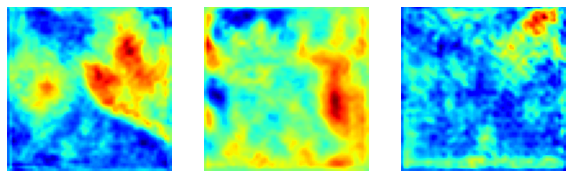

23/23 [==============================] - 47s 2s/step - loss: 2.2413 - acd: 0.2593 - lsd: 9.9834 - extreme_rmse: 0.4154 - ws_weighted_rmse: 2.2413 - spatial_ks: 0.5030
Epoch 7/50


23/23 [==============================] - 47s 2s/step - loss: 2.1800 - acd: 0.2469 - lsd: 9.7977 - extreme_rmse: 0.3994 - ws_weighted_rmse: 2.1800 - spatial_ks: 0.5062
Epoch 8/50


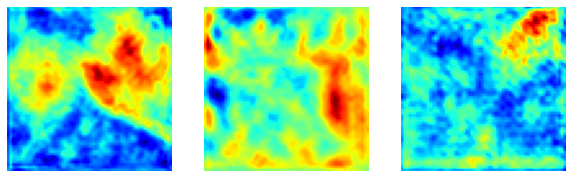

23/23 [==============================] - 46s 2s/step - loss: 2.0720 - acd: 0.2441 - lsd: 9.6629 - extreme_rmse: 0.3739 - ws_weighted_rmse: 2.0720 - spatial_ks: 0.4962
Epoch 9/50


23/23 [==============================] - 44s 2s/step - loss: 1.9882 - acd: 0.2359 - lsd: 9.5916 - extreme_rmse: 0.3576 - ws_weighted_rmse: 1.9882 - spatial_ks: 0.4885
Epoch 10/50


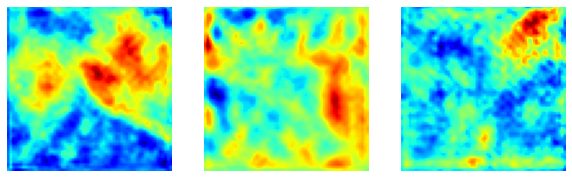

23/23 [==============================] - 44s 2s/step - loss: 1.9859 - acd: 0.2345 - lsd: 9.5602 - extreme_rmse: 0.3605 - ws_weighted_rmse: 1.9859 - spatial_ks: 0.4906
Epoch 11/50


23/23 [==============================] - 44s 2s/step - loss: 2.0119 - acd: 0.2352 - lsd: 9.6512 - extreme_rmse: 0.3663 - ws_weighted_rmse: 2.0119 - spatial_ks: 0.4841
Epoch 12/50


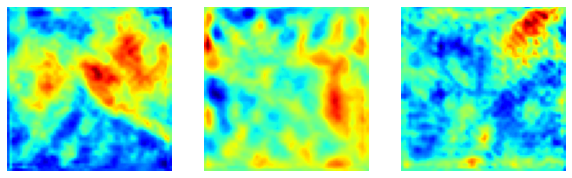

23/23 [==============================] - 46s 2s/step - loss: 2.0269 - acd: 0.2367 - lsd: 9.7178 - extreme_rmse: 0.3678 - ws_weighted_rmse: 2.0269 - spatial_ks: 0.4766
Epoch 13/50


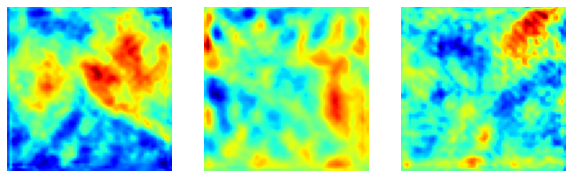

23/23 [==============================] - 46s 2s/step - loss: 1.9401 - acd: 0.2334 - lsd: 9.5222 - extreme_rmse: 0.3487 - ws_weighted_rmse: 1.9401 - spatial_ks: 0.4793
Epoch 14/50


23/23 [==============================] - 47s 2s/step - loss: 1.9082 - acd: 0.2288 - lsd: 9.5268 - extreme_rmse: 0.3429 - ws_weighted_rmse: 1.9082 - spatial_ks: 0.4680
Epoch 15/50


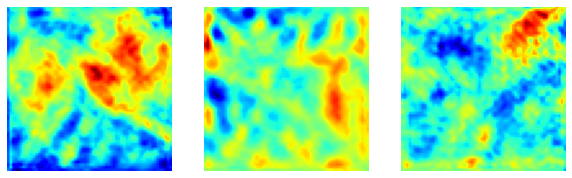

23/23 [==============================] - 51s 2s/step - loss: 1.8707 - acd: 0.2244 - lsd: 9.5045 - extreme_rmse: 0.3335 - ws_weighted_rmse: 1.8707 - spatial_ks: 0.4667
Epoch 16/50


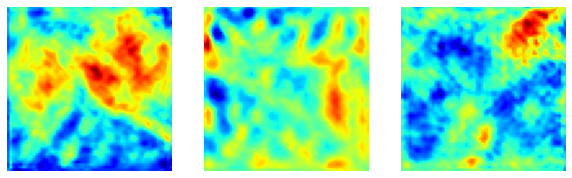

23/23 [==============================] - 58s 3s/step - loss: 1.8300 - acd: 0.2244 - lsd: 9.4218 - extreme_rmse: 0.3250 - ws_weighted_rmse: 1.8300 - spatial_ks: 0.4674
Epoch 17/50


23/23 [==============================] - 56s 2s/step - loss: 1.8129 - acd: 0.2208 - lsd: 9.4722 - extreme_rmse: 0.3205 - ws_weighted_rmse: 1.8129 - spatial_ks: 0.4588
Epoch 18/50


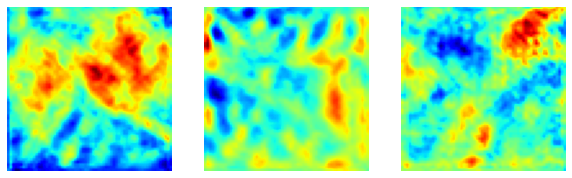

23/23 [==============================] - 53s 2s/step - loss: 1.7829 - acd: 0.2187 - lsd: 9.4162 - extreme_rmse: 0.3157 - ws_weighted_rmse: 1.7829 - spatial_ks: 0.4601
Epoch 19/50


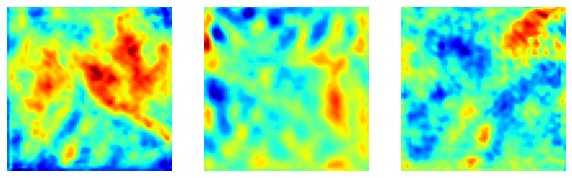

23/23 [==============================] - 53s 2s/step - loss: 1.7842 - acd: 0.2201 - lsd: 9.3860 - extreme_rmse: 0.3147 - ws_weighted_rmse: 1.7842 - spatial_ks: 0.4570
Epoch 20/50


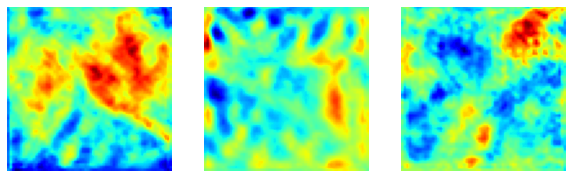

23/23 [==============================] - 55s 2s/step - loss: 1.7329 - acd: 0.2176 - lsd: 9.4412 - extreme_rmse: 0.3031 - ws_weighted_rmse: 1.7329 - spatial_ks: 0.4452
Epoch 21/50


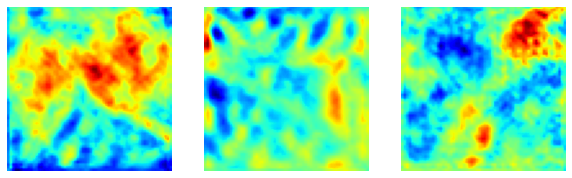

23/23 [==============================] - 50s 2s/step - loss: 1.7867 - acd: 0.2239 - lsd: 9.4337 - extreme_rmse: 0.3116 - ws_weighted_rmse: 1.7867 - spatial_ks: 0.4597
Epoch 22/50


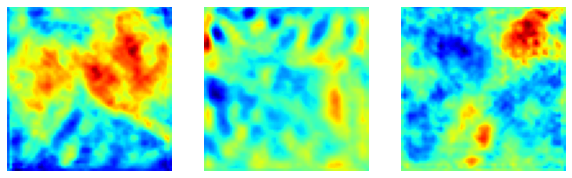

23/23 [==============================] - 48s 2s/step - loss: 1.7696 - acd: 0.2180 - lsd: 9.3886 - extreme_rmse: 0.3096 - ws_weighted_rmse: 1.7696 - spatial_ks: 0.4459
Epoch 23/50


23/23 [==============================] - 48s 2s/step - loss: 1.7165 - acd: 0.2158 - lsd: 9.3366 - extreme_rmse: 0.2999 - ws_weighted_rmse: 1.7165 - spatial_ks: 0.4450
Epoch 24/50


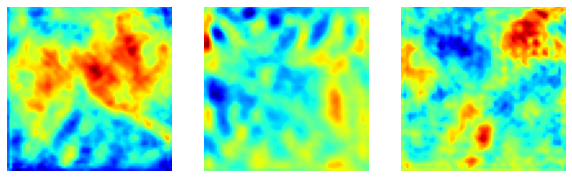

23/23 [==============================] - 48s 2s/step - loss: 1.7446 - acd: 0.2211 - lsd: 9.3797 - extreme_rmse: 0.3040 - ws_weighted_rmse: 1.7446 - spatial_ks: 0.4515
Epoch 25/50


23/23 [==============================] - 54s 2s/step - loss: 1.7055 - acd: 0.2130 - lsd: 9.4347 - extreme_rmse: 0.2981 - ws_weighted_rmse: 1.7055 - spatial_ks: 0.4340
Epoch 26/50


23/23 [==============================] - 54s 2s/step - loss: 1.6714 - acd: 0.2087 - lsd: 9.2937 - extreme_rmse: 0.2869 - ws_weighted_rmse: 1.6714 - spatial_ks: 0.4410
Epoch 27/50


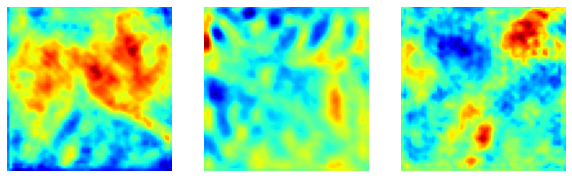

23/23 [==============================] - 52s 2s/step - loss: 1.6891 - acd: 0.2122 - lsd: 9.4909 - extreme_rmse: 0.2959 - ws_weighted_rmse: 1.6891 - spatial_ks: 0.4250
Epoch 28/50


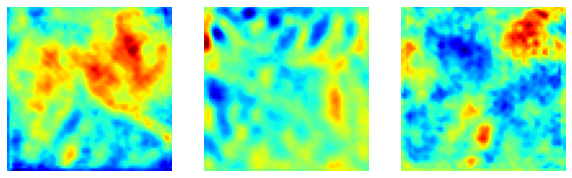

23/23 [==============================] - 52s 2s/step - loss: 1.6055 - acd: 0.2050 - lsd: 9.3025 - extreme_rmse: 0.2762 - ws_weighted_rmse: 1.6055 - spatial_ks: 0.4278
Epoch 29/50


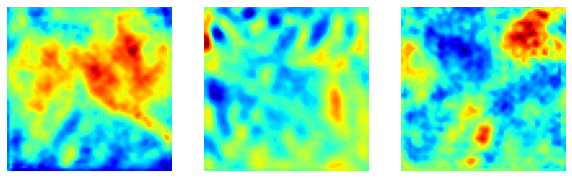

23/23 [==============================] - 51s 2s/step - loss: 1.6003 - acd: 0.2062 - lsd: 9.2505 - extreme_rmse: 0.2743 - ws_weighted_rmse: 1.6003 - spatial_ks: 0.4227
Epoch 30/50


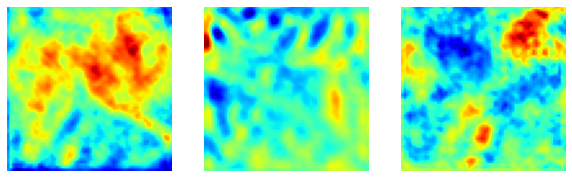

23/23 [==============================] - 54s 2s/step - loss: 1.6715 - acd: 0.2108 - lsd: 9.3650 - extreme_rmse: 0.2856 - ws_weighted_rmse: 1.6715 - spatial_ks: 0.4339
Epoch 31/50


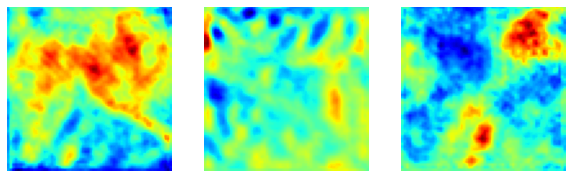

23/23 [==============================] - 50s 2s/step - loss: 1.6215 - acd: 0.2055 - lsd: 9.4009 - extreme_rmse: 0.2795 - ws_weighted_rmse: 1.6215 - spatial_ks: 0.4230
Epoch 32/50


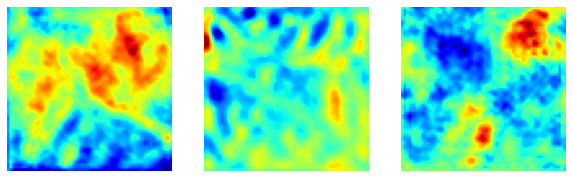

23/23 [==============================] - 52s 2s/step - loss: 1.6407 - acd: 0.2094 - lsd: 9.4438 - extreme_rmse: 0.2783 - ws_weighted_rmse: 1.6407 - spatial_ks: 0.4303
Epoch 33/50


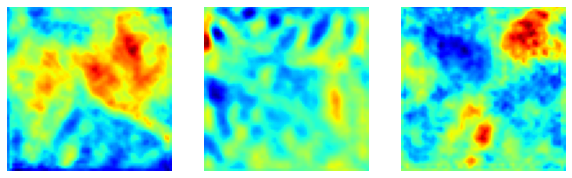

23/23 [==============================] - 50s 2s/step - loss: 1.5811 - acd: 0.2031 - lsd: 9.2584 - extreme_rmse: 0.2695 - ws_weighted_rmse: 1.5811 - spatial_ks: 0.4250
Epoch 34/50


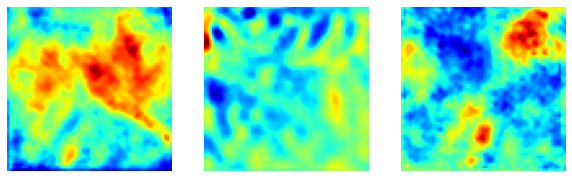

23/23 [==============================] - 85s 4s/step - loss: 1.6056 - acd: 0.2086 - lsd: 9.2806 - extreme_rmse: 0.2753 - ws_weighted_rmse: 1.6056 - spatial_ks: 0.4237
Epoch 35/50


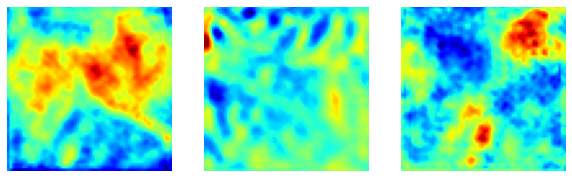

23/23 [==============================] - 49s 2s/step - loss: 1.6633 - acd: 0.2110 - lsd: 9.4370 - extreme_rmse: 0.2884 - ws_weighted_rmse: 1.6633 - spatial_ks: 0.4304
Epoch 36/50


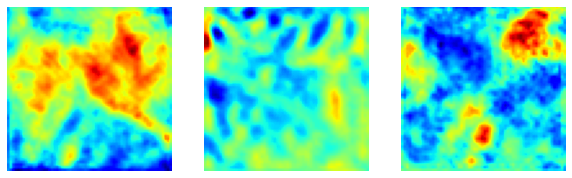

23/23 [==============================] - 51s 2s/step - loss: 1.5613 - acd: 0.2011 - lsd: 9.3746 - extreme_rmse: 0.2687 - ws_weighted_rmse: 1.5613 - spatial_ks: 0.4111
Epoch 37/50


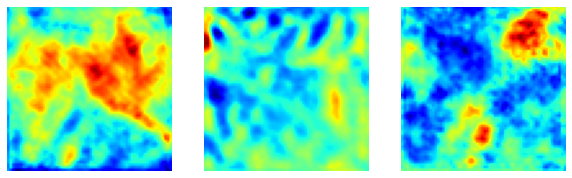

23/23 [==============================] - 52s 2s/step - loss: 1.5751 - acd: 0.2056 - lsd: 9.3203 - extreme_rmse: 0.2690 - ws_weighted_rmse: 1.5751 - spatial_ks: 0.4149
Epoch 38/50


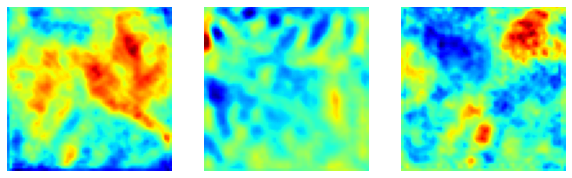

23/23 [==============================] - 75s 3s/step - loss: 1.5567 - acd: 0.2034 - lsd: 9.3707 - extreme_rmse: 0.2661 - ws_weighted_rmse: 1.5567 - spatial_ks: 0.4113
Epoch 39/50


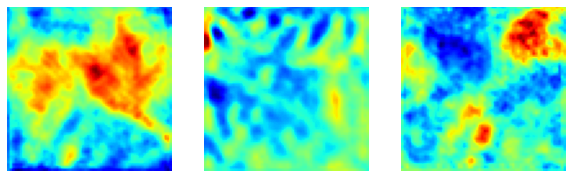

23/23 [==============================] - 96s 4s/step - loss: 1.5335 - acd: 0.2021 - lsd: 9.3382 - extreme_rmse: 0.2620 - ws_weighted_rmse: 1.5335 - spatial_ks: 0.4079
Epoch 40/50


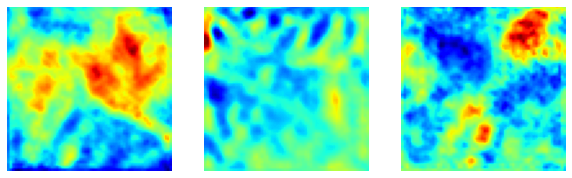

23/23 [==============================] - 57s 2s/step - loss: 1.5204 - acd: 0.2008 - lsd: 9.3272 - extreme_rmse: 0.2584 - ws_weighted_rmse: 1.5204 - spatial_ks: 0.4016
Epoch 41/50


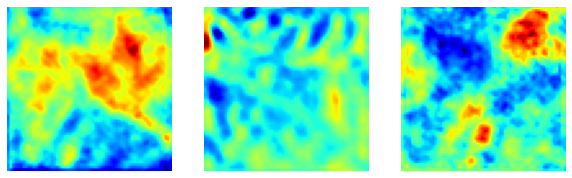

23/23 [==============================] - 49s 2s/step - loss: 1.4928 - acd: 0.1980 - lsd: 9.3472 - extreme_rmse: 0.2517 - ws_weighted_rmse: 1.4928 - spatial_ks: 0.3953
Epoch 42/50


23/23 [==============================] - 47s 2s/step - loss: 1.5337 - acd: 0.2005 - lsd: 9.3656 - extreme_rmse: 0.2609 - ws_weighted_rmse: 1.5337 - spatial_ks: 0.4077
Epoch 43/50


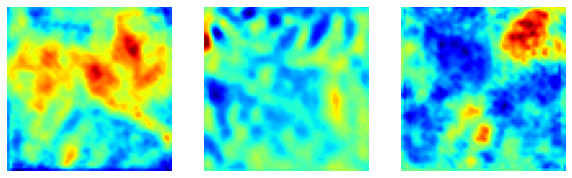

23/23 [==============================] - 63s 3s/step - loss: 1.5070 - acd: 0.1998 - lsd: 9.2805 - extreme_rmse: 0.2521 - ws_weighted_rmse: 1.5070 - spatial_ks: 0.4056
Epoch 44/50


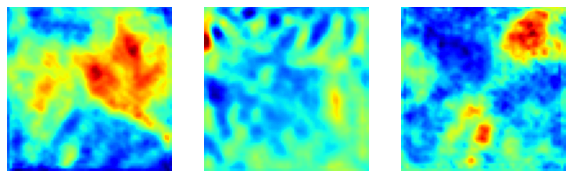

23/23 [==============================] - 98s 4s/step - loss: 1.5427 - acd: 0.1992 - lsd: 9.2913 - extreme_rmse: 0.2622 - ws_weighted_rmse: 1.5427 - spatial_ks: 0.4085
Epoch 45/50


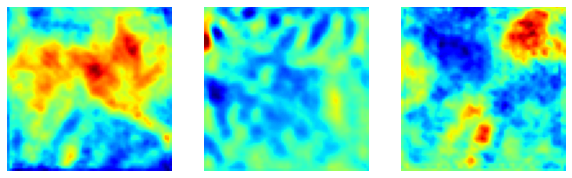

23/23 [==============================] - 96s 4s/step - loss: 1.4892 - acd: 0.1967 - lsd: 9.4632 - extreme_rmse: 0.2573 - ws_weighted_rmse: 1.4892 - spatial_ks: 0.3868
Epoch 46/50


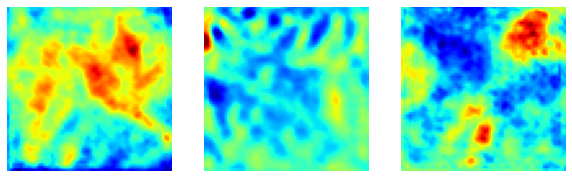

23/23 [==============================] - 105s 5s/step - loss: 1.5095 - acd: 0.2021 - lsd: 9.2753 - extreme_rmse: 0.2574 - ws_weighted_rmse: 1.5095 - spatial_ks: 0.4047
Epoch 47/50


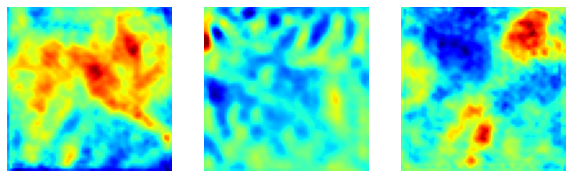

23/23 [==============================] - 99s 4s/step - loss: 1.4989 - acd: 0.2000 - lsd: 9.3839 - extreme_rmse: 0.2558 - ws_weighted_rmse: 1.4989 - spatial_ks: 0.3962
Epoch 48/50


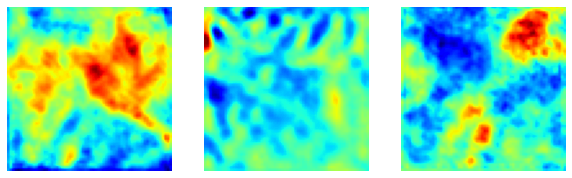

 1/23 [>.............................] - ETA: 3:05 - loss: 1.4798 - acd: 0.2048 - lsd: 9.2636 - extreme_rmse: 0.2528 - ws_weighted_rmse: 1.4798 - spatial_ks: 0.3905

In [ ]:
generator.fit(x=inputs, y=outputs, callbacks=callbacks, epochs=50)